# Objectives:

<del>1.Read particle file Current Weighting and X-Y location at the highest magnitude Z-location

<del>2.Read particle file Power Weighting and X-Y location at the highest magnitude Z-location

3.Plot 2-D intensity of current or power as a function of X or Y at a line intersection or region of interest (slices of the beam shape).

<del>4.Plot 3-D density of current or power vs X/Y (The whole of the beam shape)

5.User interface: Scale the axes appropriately (what does that mean?)

6.We needs ability to adjust the scaling of each axis (X/Y/Current/Power)

7.We need the ability to use the bin “area size” to calculate density plots of power and current\n

8.Hence we need to have a good bin size automation tool based on the total number of Z-intersecting particles, the total area, and the error variable.

9.User interface: X and Y to be in user selected measure of length (inches and meters)

10.User interface: Algorithms for Gaussian and “Top Hat” shapes, and FFT analysis as a stretch goal

11.User interface: Able to modify the algorithm variables and coefficients

12.Save images

13.Save bin files

14.Document script

In [1]:
import physt
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from   scipy       import stats
from   scipy.stats import kde
from   matplotlib  import colors
from   physt       import h1, h2, histogramdd

In [2]:
%matplotlib inline

#### Needs to account for:
(1) # particles used which strike the target anode, \
(2) cross sectional area containing particles which strike target anode, \
(3) random effects on statistical error.

In [3]:
x_in      = [] # particle x-position in [inches].
y_in      = [] # particle y-position.
z_in      = [] # particle z-position.

p_I       = [] # particle current    in [Amperes].
p_KP      = [] # particle power      in [Watts].

In [4]:
file_name = 'quick_input.out'

## Import some data set values

In [5]:
with open(file_name) as file:
    data = pd.read_csv(file, delimiter='\t', header=2, skipfooter=1, engine='python')
    
    x_in  = data['x[in]'] * 2.54 # converted inches into centimeters.
    y_in  = data['y[in]'] * 2.54
    z_in  = data['z[in]'] * 2.54
    p_I   = data['pI[A]']
    p_KP = data['pKP[W]']

# Let's exclude data points which never reach the target.
z_target = stats.mode(z_in) # We find the mode of our z_in data set: assume target's z-value.
invalids = []
for i,z in enumerate(z_in):
    if z != z_target[0]:
        invalids.append(i)  # Obtain indices of z-coords which do not equal target's.
        
# Remove data points for these particles which "miss".
x_in = np.delete(np.array(x_in),invalids)
y_in = np.delete(np.array(y_in),invalids)
z_in = np.delete(np.array(z_in),invalids)
p_I  = np.delete(np.array(p_I), invalids)
p_KP = np.delete(np.array(p_KP),invalids)

### Power weighting

In [6]:
weighting = p_KP # We can easily switch global weights for either current or power.

In [7]:
dl = 1e-3 # cm*1e-3 = decimilimeters = 1e-5 meters.
m  = 5    # Some integer to offset borders and get better view.

Wall time: 2.4 s


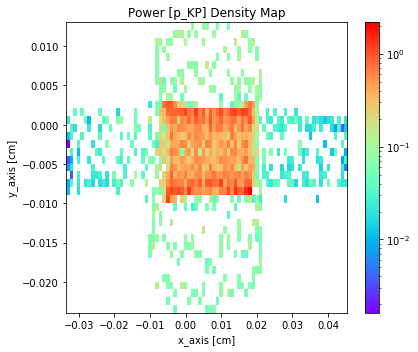

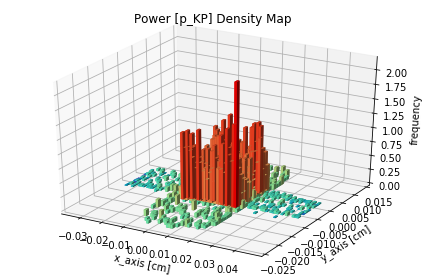

In [8]:
%%time
fig, ax = plt.subplots(figsize=(6, 5)) # Set some arbitrary figure size.
h_2     = h2(x_in, y_in, bins=[np.arange(x_in.min(),x_in.max(),dl),
                           np.arange(y_in.min(),y_in.max(),dl)], weights=weighting,
                           axis_names=["x_axis [cm]", "y_axis [cm]"], name="Power [p_KP] Density Map",aspect=1)

# Plot a 2-D histogram using x_in, y_in, and dl for binning. 
h_2.plot("image", cmap="rainbow", ax=ax, cmap_normalize="log")
# Plot shows image, normalized by a logarithmic scale.
h_2.plot("bar3d", cmap="rainbow", cmap_normalize="log");

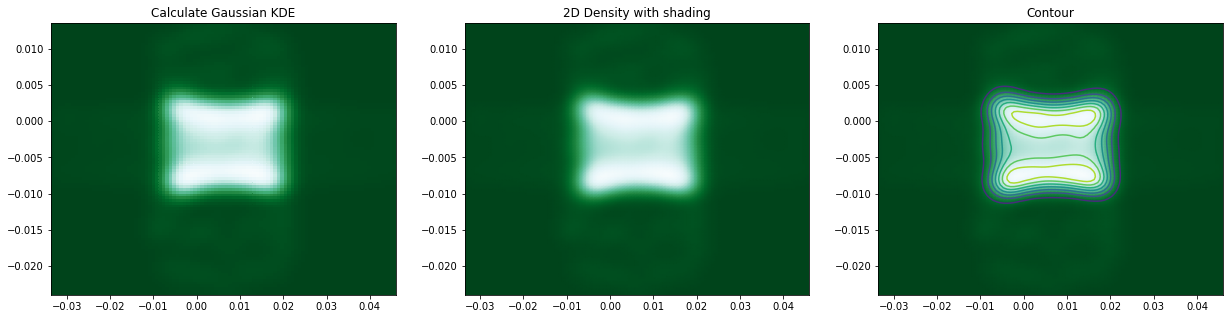

In [9]:
# Create a figure with 3 plot areas
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(21, 5))
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins     = 100
k         = kde.gaussian_kde([x_in,y_in], bw_method='scott', weights=weighting)
xi, yi    = np.mgrid[x_in.min():x_in.max():nbins*1j, y_in.min():y_in.max():nbins*1j]
zi        = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# plot a density
axes[0].set_title('Calculate Gaussian KDE')
axes[0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.BuGn_r)
 
# add shading
axes[1].set_title('2D Density with shading')
axes[1].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
 
# contour
axes[2].set_title('Contour')
axes[2].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
axes[2].contour(xi, yi, zi.reshape(xi.shape))

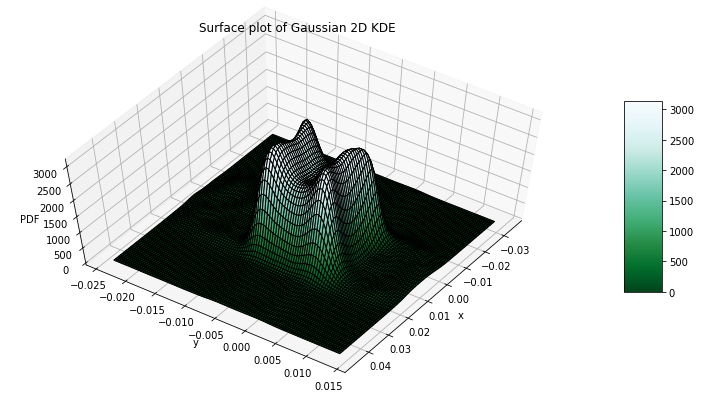

In [24]:
fig  = plt.figure(figsize=(13, 7))
ax   = plt.axes(projection='3d')
surf = ax.plot_surface(xi, yi, zi.reshape(xi.shape), rstride=1, cstride=1, cmap='BuGn_r', edgecolor='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')

fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

In [11]:
# we have access to the intensity at each bin space:
h_2.frequencies.shape

(79, 37)

In [12]:
np.sum(h_2.frequencies,axis=1).shape

(79,)

In [13]:
h_2.numpy_bins[0][:-1].shape

(79,)

In [14]:
sum(h_2.frequencies.T).shape

(79,)

#### X-Y Projection

## Right now, the bandwidth is arbitrary and the KDE is off by factor of 1/5 now 1/25 for 0-Enpa.out??

79
2931
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


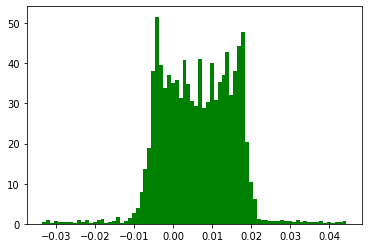

In [15]:
# xproj = h_2.projection("x_axis [cm]", name="projection to x-axis")
# xproj.plot(errors=True);

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = len(h_2.numpy_bins[0][:-1])
ind = np.linspace(x_in.min()-m*dl,x_in.max()+m*dl,nbins)
gkde = kde.gaussian_kde(x_in,weights=weighting)
gkde.set_bandwidth(0.05)

# These match the physt projection exactly...
# plt.plot(h_2.numpy_bins[0][:-1],sum(h_2.frequencies.T),'g')
plt.hist(x_in,bins=h_2.numpy_bins[0][:-1],color='g',weights=weighting,density=True)

print(len(h_2.numpy_bins[0][:-1]))

kdepdf         = gkde.evaluate(ind)
w              = np.divide(x_in,(np.sum(x_in)))
uniqw, inverse = np.unique(w, return_inverse=True)
density        = np.bincount(inverse, weights=None, minlength=0)
#(density = counts / (sum(counts) * np.diff(bins)))
print(len(density))

array = np.zeros(88)
i,p = np.linspace(-100,100,89,retstep=True)

# j=0
# for i in np.linspace(-100,100,89,retstep=True):
#     for x in x_in:
#         if (x>(i)*dl and x<(i+p)*dl):
#             j+=1
#             array[j]+= 1

print(array)

# plt.plot(ind, kdepdf,label='kde',color="r",linewidth=2)



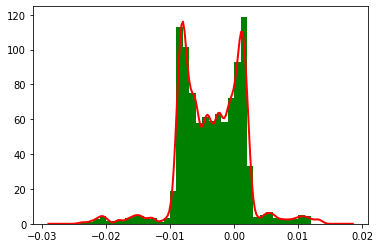

In [16]:
# yproj = h_2.projection("y_axis [cm]", name="projection to y-axis")
# yproj.plot(errors=True);

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = 200
ind = np.linspace(y_in.min()-m*dl,y_in.max()+m*dl,nbins)
gkde = kde.gaussian_kde(y_in,bw_method='scott',weights=weighting)

# plt.plot(h_2.numpy_bins[1][:-1],sum(h_2.frequencies),'g')
plt.hist(y_in,bins=h_2.numpy_bins[1][:-1],color='g',weights=weighting,density=True)

gkde.set_bandwidth(0.1)
kdepdf = gkde.evaluate(ind)
plt.plot(ind, kdepdf,label='kde',color="r",linewidth=2)


## Variable slice for x-projection histogram?
#### Axes for these two graphs won't rescale to input lengths...

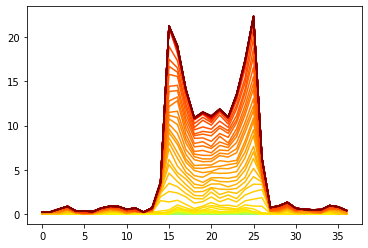

In [17]:
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0.5, 1, len(h_2.frequencies)))))
                         
for f in range(len(h_2.frequencies)):
    plt.plot(sum(h_2.frequencies[:f]),'-');
#y-axis cumulative

In [18]:
print(sum(h_2.frequencies[:20]))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.0580929  0.38681497 0.31865235
 0.08953913 0.2016973  0.1738036  0.16774468 0.2274598  0.20726145
 0.3694305  0.1933496  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


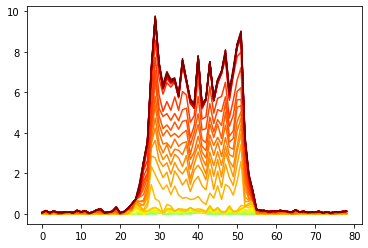

In [19]:
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0.5, 1, len(h_2.frequencies.T)))))
for f in range(len(h_2.frequencies.T)):
    plt.plot(sum(h_2.frequencies.T[:f]),'-');
#x-axis cumulative

ValueError: x and y must have same first dimension, but have shapes (89,) and (79,)

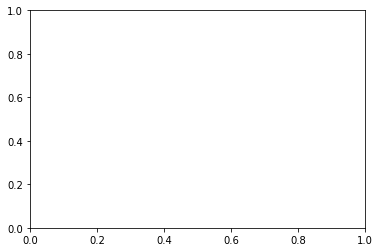

In [20]:
f=1
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0.25, 1, len(h_2.frequencies.T)))))
for i in range(len(h_2.frequencies.T)):
    plt.plot(np.arange(np.amin(x_in)-m*dl,np.amax(x_in)+m*dl,dl)[:-1],sum(h_2.frequencies.T[i:f]),'-');
    f += 1
    
plt.plot(np.arange(np.amin(x_in)-m*dl,np.amax(x_in)+m*dl,dl)[:-1],
         sum(h_2.frequencies.T[:len(h_2.frequencies.T)]),'-');

In [ ]:
f=1
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0.25, 1, len(h_2.frequencies)))))
for i in range(len(h_2.frequencies)):
    plt.plot(np.arange(np.amin(y_in)-m*dl,np.amax(y_in)+m*dl,dl)[:-1],sum(h_2.frequencies[i:f]),'-');
    f += 1
    
plt.plot(np.arange(np.amin(y_in)-m*dl,np.amax(y_in)+m*dl,dl)[:-1],
         sum(h_2.frequencies[:len(h_2.frequencies)]),'-');